In [1]:
from numpy import *
from numpy import fft as fft
from pandas import read_csv
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.stats import LombScargle
from scipy import signal
from detect_peaks import *
import uncertainties as unc
from uncertainties import unumpy as unp

def gaussian(height,center,fwhm,xvec):
    e=(-4*np.log(2)**2*(xvec-center)**2)/(fwhm**2)
    g=height*np.exp(e)
    return -g

def whiten(timeflux, minpeak,  low, upp, quarter = '', nit = 5, p = False):
    n = 1
    if p == True:
        f, axarr = plt.subplots(nit-1, sharex = True, sharey = True, figsize=(15,15))
    time = timeflux[0]
    phase = timeflux[1]
    flux = timeflux[2]
    while n < nit:
        flux = flux-mean(flux)
        if p == True:
            axarr[n-1].scatter(phase,flux,marker='+',color='b')
        freq, power = LombScargle(phase,flux).autopower()
        peak = power.argmax()
        best = freq[peak]
        if best < minpeak:
            print("Peak too small")
            break
        else:
            y = LombScargle(phase,flux).model(phase,best)
            if p == True:
                axarr[n-1].plot(phase,y,color='r')
                ylim(low,upp)
            flux = subtract(flux, y)
            n = n + 1
    plt.setp([a.get_xticklabels() for a in axarr[0:-1]], visible=False)
    plt.xlabel('Phase')
    f.text(0.04,0.5,'Whitened Relative Flux (electrons/s)', va = 'center', rotation='vertical')
    axarr[0].set_title('Lomb-Scargle Whitening' + ', Q'+quarter)
    savefig('white'+quarter)
    show()
    return asarray([time,phase,flux,timeflux[3],timeflux[4]])

def readclean(name, fmt, hd, cadence):
    data = asarray(Table.read(name, format = fmt, hdu = hd))
    time = []
    flux = []
    fluxerr = []
    phase = []
    tinit, tfin = data[0][0], data[-1][0]
    diff = tfin-tinit
    if cadence == 'long':
        for i in data:
            if isnan(i[4]) == False:
                time.append(i[0])
                flux.append(i[4])
                fluxerr.append(i[5])
                phase.append((i[0]-tinit)/diff)
        return asarray([time,phase,flux,fluxerr])
    elif cadence == 'short':
        for i in data:
            if isnan(i[3]) == False:
                time.append(i[0])
                flux.append(i[3])
                phase.append((i[0]-tinit)/diff)
        return asarray([time,phase,flux])
    else:
        print("Cadence not valid")
        return

In [5]:
Table.read("kplr000757450-20160128150956_dvt.fits",format = 'fits', hdu = 1)

TIME,TIMECORR,CADENCENO,PHASE,LC_INIT,LC_INIT_ERR,LC_WHITE,LC_DETREND,MODEL_INIT,MODEL_WHITE
BJD - 2454833,d,,days,dimensionless,dimensionless,dimensionless,dimensionless,dimensionless,dimensionless
float64,float32,int32,float32,float32,float32,float32,float32,float32,float32
131.512714688,-0.00172087,1105,5.9456,-0.000179398,0.000433748,-0.706973,-0.000179398,0.0,-0.0483186
131.533149402,-0.00172188,1106,5.96603,-0.000803892,0.000434269,-1.70477,-0.000803892,0.0,-0.0490852
131.553584016,-0.0017229,1107,5.98647,-0.000170948,0.000434351,-0.676844,-0.000170948,0.0,-0.0499582
131.57401853,-0.00172391,1108,6.0069,-0.000585675,0.000433849,-1.28782,-0.000585675,0.0,-0.0509355
131.594453143,-0.00172492,1109,6.02734,-0.000790366,0.000434419,-1.5524,-0.000790366,0.0,-0.0520141
131.614887857,-0.00172594,1110,6.04777,0.000140425,0.000434047,0.0172569,0.000140425,0.0,-0.0531891
131.63532237,-0.00172695,1111,6.06821,0.000386938,0.000434096,0.54727,0.000386938,0.0,-0.0544541
131.655756984,-0.00172796,1112,6.08864,0.000173515,0.00043426,0.170126,0.000173515,0.0,-0.0558023


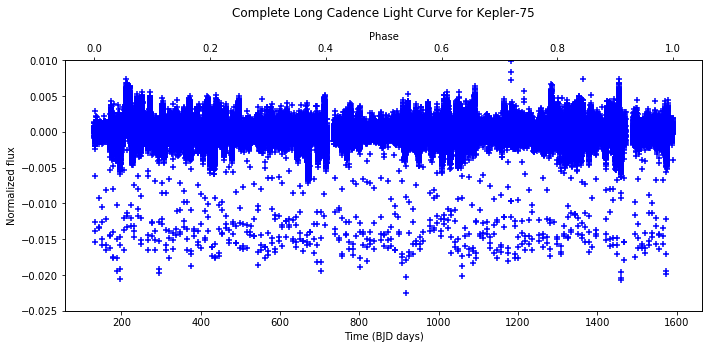

In [12]:
full = readclean('kplr000757450-2013011073258_slc.fits','fits',1,'long')
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(full[0],full[2], marker = '+', c = 'b')
ax1.set_xlabel('Time (BJD days)')
ax2.plot(full[1], -10*ones(len(full[0])))
ax2.set_xlabel('Phase')
ax1.set_ylim(-0.025,0.01)
ax1.set_ylabel('Normalized flux')
plt.title('Complete Long Cadence Light Curve for Kepler-75', y=1.15)
plt.savefig('completelc.png')
plt.tight_layout()
plt.show()

In [15]:
minpos = detect_peaks(full[2],valley = True, mph = 0.01, mpd = 10)
dettimes = []
amp = []
err = []
for n in minpos:
    t = full[0][n]
    a = full[2][n]
    e = full[3][n]
    dettimes.append(t)
    amp.append(abs(a))
    err.append(e)
diff = []
n = 0
while n < len(dettimes)-1:
    t1 = dettimes[n]
    t2 = dettimes[n+1]
    d = t2-t1
    if d < 10:
        diff.append(d)
    n = n + 2
period, err = mean(diff), std(diff)/(len(diff)**0.5)
R = unc.ufloat(0.88,0.04)*9.951*mean(unp.uarray(amp,err))**0.5
period, err, R

(8.8854951441622276,
 0.0014310762033047158,
 1.1054805053853056+/-0.05040907719530028)

In [26]:
short = readclean("kplr000757450-2013011073258_slc.fits",'fits',1,'short')

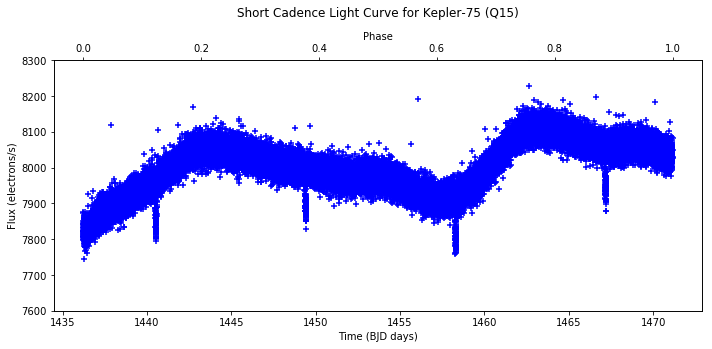

In [27]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(short[0],short[2], marker = '+', c = 'b')
ax1.set_xlabel('Time (BJD days)')
ax2.plot(short[1], ones(len(short[0])))
ax2.set_xlabel('Phase')
ax1.set_ylim(7600,8300)
ax1.set_ylabel('Flux (electrons/s)')
plt.title('Short Cadence Light Curve for Kepler-75 (Q15)', y=1.15)
plt.tight_layout()
savefig('sclc1.png')
plt.show()

In [28]:
bi = mean(short[2])

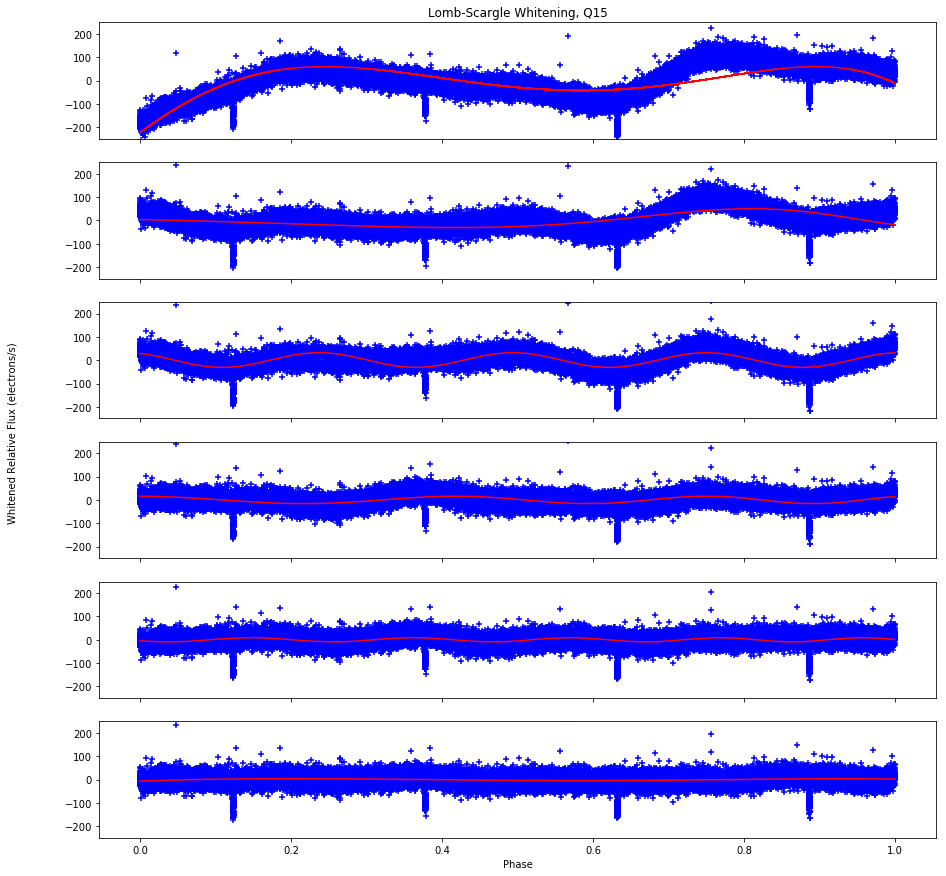

In [29]:
wshort = whiten(short,0.01,-250,250,quarter = '15',nit=7, p=True)

In [185]:
transits = detect_peaks(wshort[2],valley = True, mph = 150, mpd = 100)

In [186]:
amp = []
for t in transits:
    amp.append(abs(wshort[2][t]))
tamp = mean(amp)

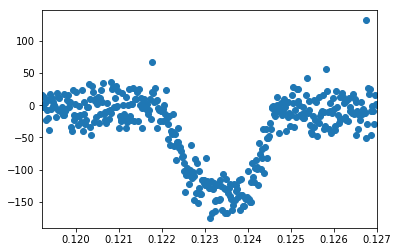

In [81]:
first = transits[0]
low,upp = first-200,first+200
trange = [wshort[1][low:upp],wshort[2][low:upp]]
scatter(trange[0],trange[1])
xlim(min(trange[0]),max(trange[0]))
show()

In [187]:
def findwidth(transit,amp):
    l = []
    for n in range(len(transit[0])):
        time = transit[0][n]
        flux = transit[1][n]
        if abs(flux) >= amp/2. and flux < 0:
            l.append(time)
    return l[-1]-l[0]

In [188]:
wlist = []
for n in range(len(amp)):
    low,upp = transits[n]-200,transits[n]+200
    trange = [wshort[1][low:upp], wshort[2][low:upp]]
    w = findwidth(trange, amp[n])
    wlist.append(w)
wav = mean(wlist)

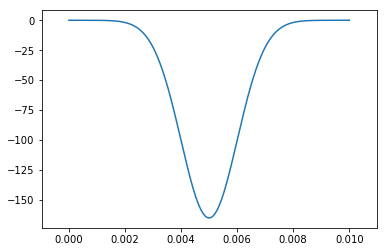

In [189]:
tvec = linspace(0,0.01,1000)
gauss = gaussian(tamp,0.005,wav,tvec)
plot(tvec,gauss)
xlim(0.005-3*w,0.005+3*w)
show()

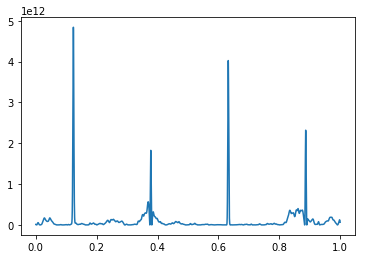

In [190]:
ccf = signal.correlate(wshort[2],gauss,mode='same')
plot(wshort[1],abs(ccf)**2)
show()

In [191]:
ploc = detect_peaks(ccf, mph = 500000, mpd = 1000)
avamp = []
for p in ploc:
    l,u = p-10,p+10
    av = mean(wshort[2][l:u])
    avamp.append(abs(av))
imptamp = abs(mean(avamp))

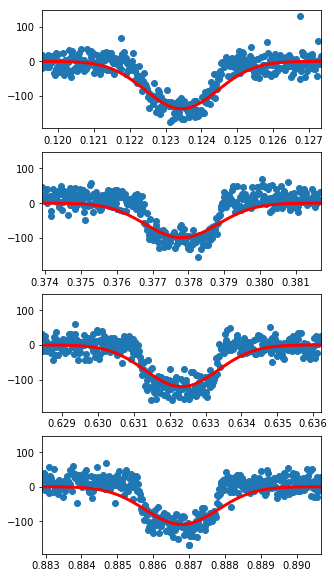

In [192]:
f, axarr = plt.subplots(len(ploc), sharey = True, figsize=(5,10))
for n in range(len(ploc)):
    p = ploc[n]
    l,u = p-200,p+200
    trange = [wshort[1][l:u],wshort[2][l:u]]
    axarr[n].scatter(trange[0],trange[1])
    axarr[n].plot(trange[0],gaussian(avamp[n],wshort[1][p],w,trange[0]),c = 'r', linewidth = 3.0)
    axarr[n].set_xlim([min(trange[0]),max(trange[0])])
show()

In [193]:
dettimes = []
diff = []
n = 0
for p in ploc:
    dettimes.append(wshort[0][p])
while n < len(dettimes)-1:
    t1 = dettimes[n]
    t2 = dettimes[n+1]
    d = t2-t1
    if d < 10:
        diff.append(d)
    n = n + 2
mean(diff)

8.8838005734105536

In [194]:
ploc

array([ 6318, 19324, 32340, 45353])

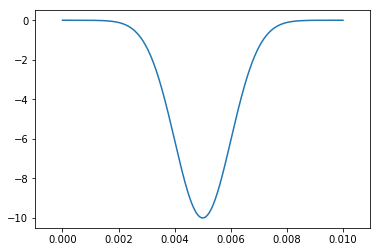

In [125]:
tvec = linspace(0,0.01,1000)
gauss = gaussian(10,0.005,wav,tvec)
plot(tvec,gauss)
xlim(0.005-3*w,0.005+3*w)
show()

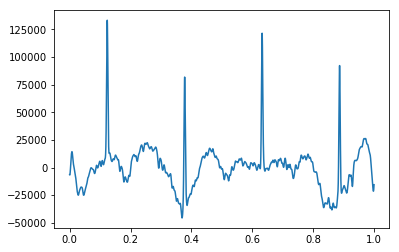

In [126]:
ccf = signal.correlate(wshort[2],gauss,mode='same')
plot(wshort[1],ccf)
show()

In [129]:
ploc2 = detect_peaks(ccf, mph = 50000, mpd = 1000)
dettimes = []
diff = []
n = 0
for p in ploc2:
    dettimes.append(wshort[0][p])
while n < len(dettimes)-1:
    t1 = dettimes[n]
    t2 = dettimes[n+1]
    d = t2-t1
    if d < 10:
        diff.append(d)
    n = n + 2
mean(diff)

8.8838005734105536

In [124]:
ploc2

array([ 6318, 19324, 32340, 45353])

In [ ]:
while n < len(dettimes)-1:
    t1 = dettimes[n]
    t2 = dettimes[n+1]
    d = t2-t1
    if d < 10:
        diff.append(d)
    n = n + 2
mean(diff)

In [35]:
coeff = (bi-tamp)/bi
R = 0.88*9.951*(1-coeff)**0.5

1.0475604049931151

In [72]:
short2 = readclean("kplr000757450-2011208035123_slc.fits",'fits',1,'short')

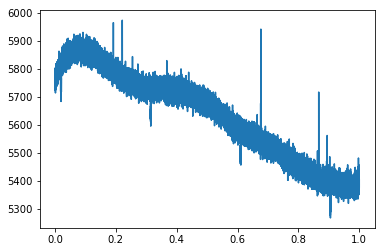

In [73]:
plot(short2[1],short2[2])
show()

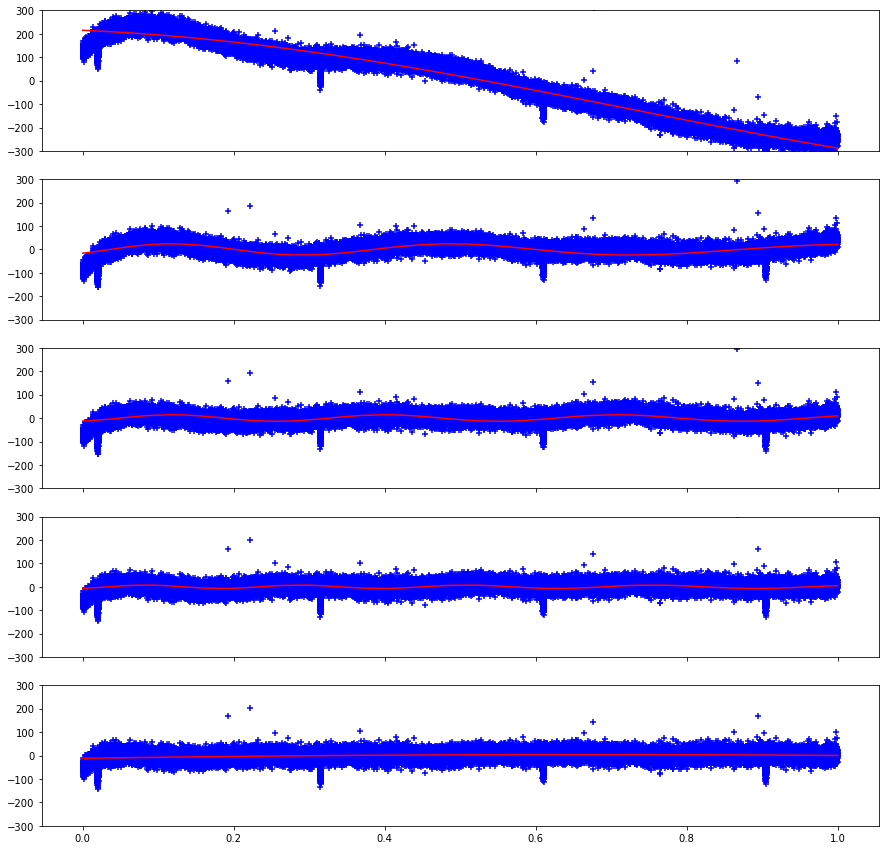

In [74]:
wshort2 = whiten(short2,0.01,-300,300,nit=6, p=True)

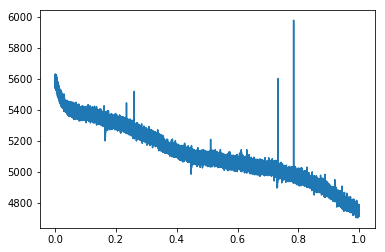

In [75]:
short3 = readclean("kplr000757450-2011240104155_slc.fits",'fits',1,'short')
plot(short3[1],short3[2])
show()

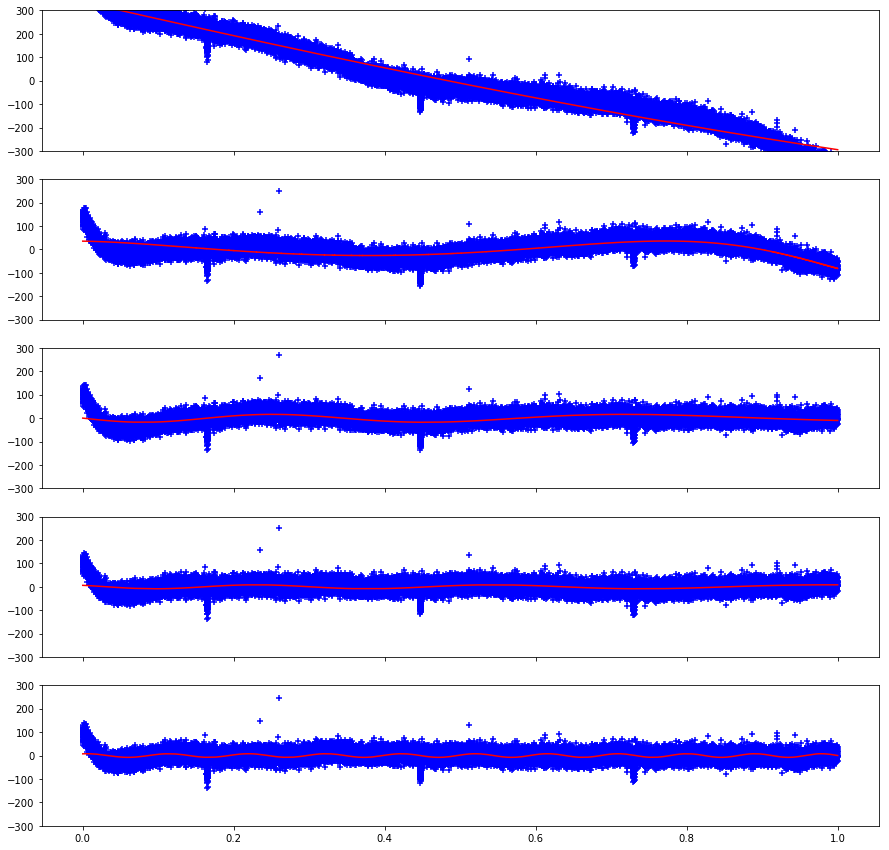

In [76]:
wshort3 = whiten(short3,0.01,-300,300,nit=6, p=True)